In [27]:
%matplotlib notebook
import cameratransform as ct
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from haversine import haversine, Unit

### Import calibration image for camera 1 (1280x960 resolution) and undistort
I'm fairly sure that the camera matrix for this resolution has the wrong optical centre, as it is very similar to the 640x480 resolution. Assuming that the optical centre should be in the centre of the image, so am multiplying the values in the matrix by 2 so that the pixel coordinate is roughly in the centre of the image.

<IPython.core.display.Javascript object>


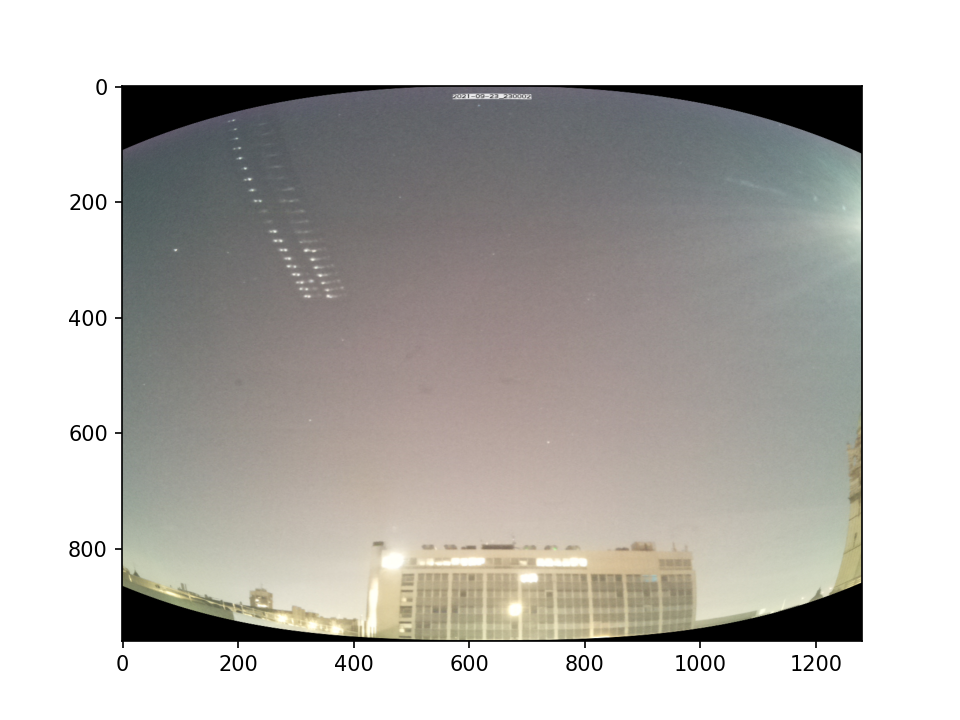

In [3]:
camM = np.array([[5.063166013857816665e+02,0.000000000000000000e+00,2*3.166661931952413056e+02],
                [0.000000000000000000e+00,5.067357512519903935e+02,2*2.526423174030390157e+02],
                [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
distortion = np.array([2.326755157584974587e-01,-6.011054678561147391e-01,3.963575587693899294e-04,-2.566491984608918874e-04,4.822591716560123420e-01])
w, h = 1280, 960

filepath = r"C:/Users/kathe/OneDrive - Imperial College London\MSci Project/longExposures/"
filename = f'tl_2021-09-23_230002_CAL1.jpg'

im = plt.imread(filepath+filename)

new_camM, roi = cv.getOptimalNewCameraMatrix(camM,distortion,(w,h),1,(w,h))

im_undistorted = cv.undistort(im, camM, distortion, None, new_camM)
fig, ax = plt.subplots(1,1)
ax.imshow(im_undistorted)

#plt.savefig('calib_undistorted_1280x960.png', bbox_inches='tight')

### Resize image to 640x480 to find pixel coordinates in lower resolution

i.e. undistort image using the camera matrix and distortion coefficients for the lower resolution

<IPython.core.display.Javascript object>


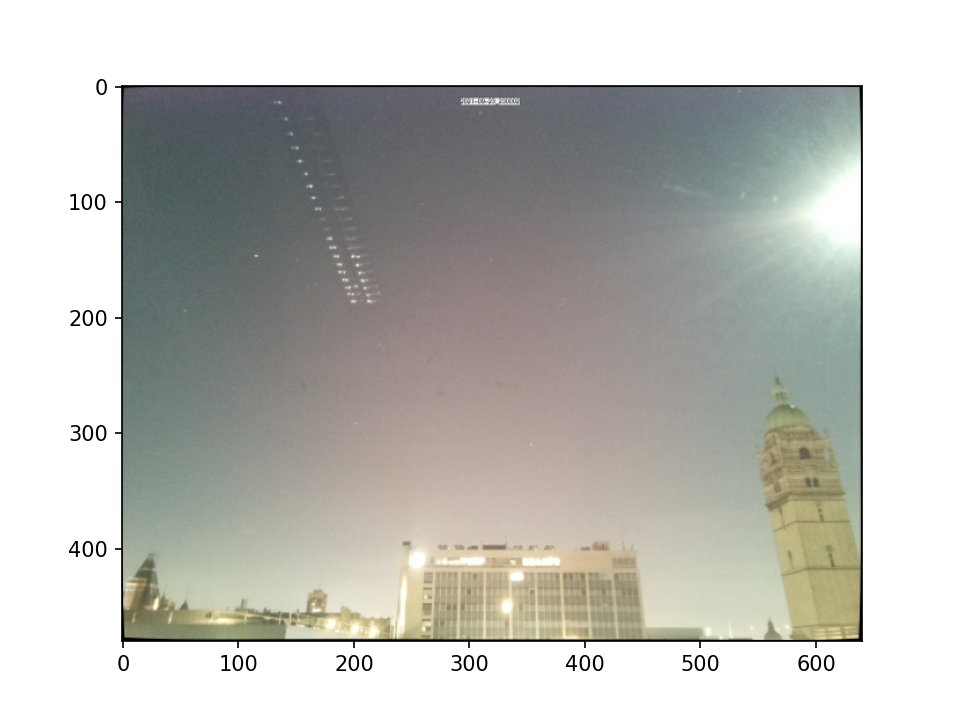

In [7]:
im_low_res = cv.resize(im,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)
w1,h1 = 640,480

camM_low_res = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
distortion_low_res = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])

new_camM_low_res, roi = cv.getOptimalNewCameraMatrix(camM_low_res,distortion_low_res,(w1,h1),1,(w1,h1))

im_undistorted_low_res = cv.undistort(im_low_res, camM_low_res, distortion_low_res, None, new_camM_low_res)
fig, ax = plt.subplots(1,1)
ax.imshow(im_undistorted_low_res)

#plt.savefig('calib_undistorted_640x480.png', bbox_inches='tight')

In [13]:
# intrinsic camera parameters
f_mm = 3.04    # in mm
pixel_size = 1.12e-3 # length of one side of square pixel in mm
sensor_size = (3.68, 2.76) # in mm
image_size = (1280, 960)    # in px
image_size_lowres = (640, 480) #in 
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height


# initialize the camera
# camera is using the original 1280x960 image without any undistortion
# camera2 is using the undistorted 640x480 image
# camera3 is using the undistorted 1280x960 image
camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = im))
camera2 = ct.Camera(ct.RectilinearProjection(focallength_px = f_mm/pixel_size, image = im_undistorted_low_res))
camera3 = ct.Camera(ct.RectilinearProjection(focallength_px = f_mm/pixel_size, image = im_undistorted))

camera.setGPSpos(51.49880908055068, -0.1788492157810761, 30)
camera2.setGPSpos(51.49880908055068, -0.1788492157810761, 30)
camera3.setGPSpos(51.49880908055068, -0.1788492157810761, 30)

lm_points_px = np.array([[1135.4,503.9], [342,863.3], [1122,922.83]]) #queens tower, peninsula tower, brompton oratory
lm_points_px_1280 = np.array([[241.1,859.8], [1208.0,863.6]]) #peninsula tower, brompton oratory
lm_points_px_640 = np.array([[565.0,247.82], [170.45,429.91],[559.10,457.74]])
lm_points_gps = np.array([[51.498342738054035, -0.1768382060138951, 87], 
                          [51.502, -0.167, 94], 
                          [51.49723597996239, -0.1696021165279743, 61]])
lm_points_space = camera.spaceFromGPS(lm_points_gps)
lm_points_space_640 = camera2.spaceFromGPS(lm_points_gps)
lm_points_space_1280 = camera3.spaceFromGPS(lm_points_gps)

camera.addLandmarkInformation(lm_points_px[1:, :], lm_points_space[1:, :], [3, 3, 5]) #last argument is the uncertainty in each gps coordinate
camera2.addLandmarkInformation(lm_points_px_640[1:, :], lm_points_space_640[1:, :], [3, 3, 5])
camera3.addLandmarkInformation(lm_points_px_1280, lm_points_space_1280[1:, :], [3, 3, 5])

In [17]:
# find trace through the parameter space
trace = camera.metropolis([
        ct.FitParameter("elevation_m", lower=29, upper=31, value=30),
        ct.FitParameter("tilt_deg", lower=0, upper=180, value=90),
        ct.FitParameter("heading_deg", lower=-180, upper=180, value=90),
        ct.FitParameter("roll_deg", lower=-20, upper=20, value=-0.6)
        ], iterations=1e4)

100%|██████████| 10000/10000 [01:23<00:00, 119.81it/s, acc_rate=0.176, factor=0.0164]


      elevation_m    tilt_deg  heading_deg  roll_deg   probability
0       29.932834  114.721086    80.929349  2.499399 -20634.693606
1       29.932834  114.721086    80.929349  2.499399 -20634.693606
2       29.932834  114.721086    80.929349  2.499399 -20634.693606
3       29.932834  114.721086    80.929349  2.499399 -20634.693606
4       29.932834  114.721086    80.929349  2.499399 -20634.693606
...           ...         ...          ...       ...           ...
8994    29.894558  114.754471    80.888807  2.589696 -20636.039925
8995    29.887643  114.749774    80.893014  2.580876 -20634.137185
8996    29.887643  114.749774    80.893014  2.580876 -20634.137185
8997    29.887643  114.749774    80.893014  2.580876 -20634.137185
8998    29.887643  114.749774    80.893014  2.580876 -20634.137185

[8999 rows x 5 columns]


<IPython.core.display.Javascript object>


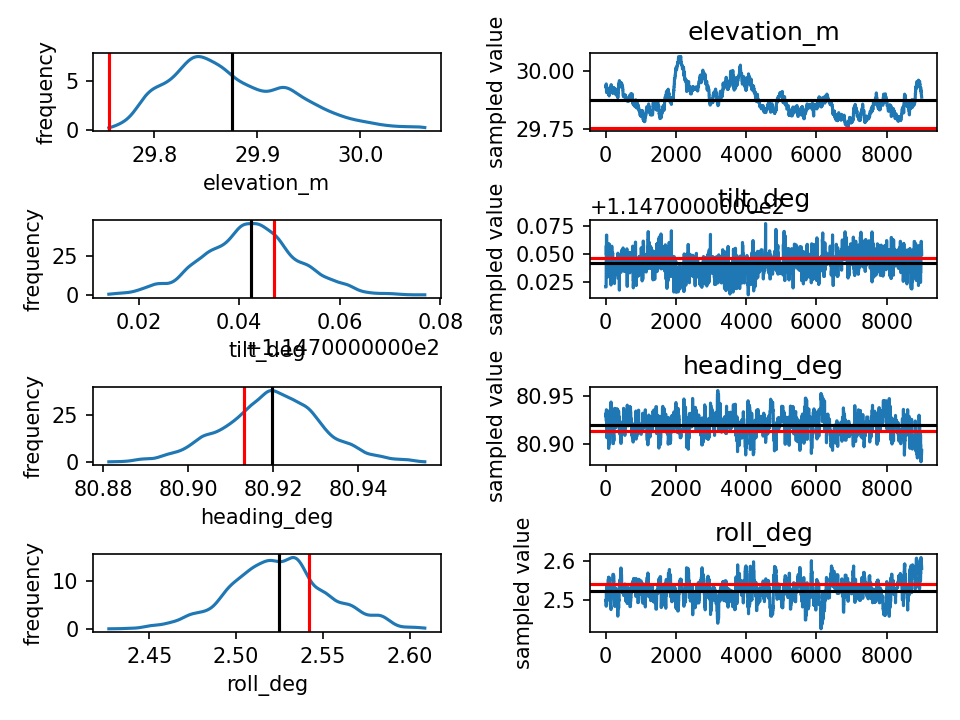

In [20]:
# plot trace through parameter space
plt.figure()
camera.plotTrace()
plt.tight_layout()
#plt.savefig('1280x640_undistorted_trace.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


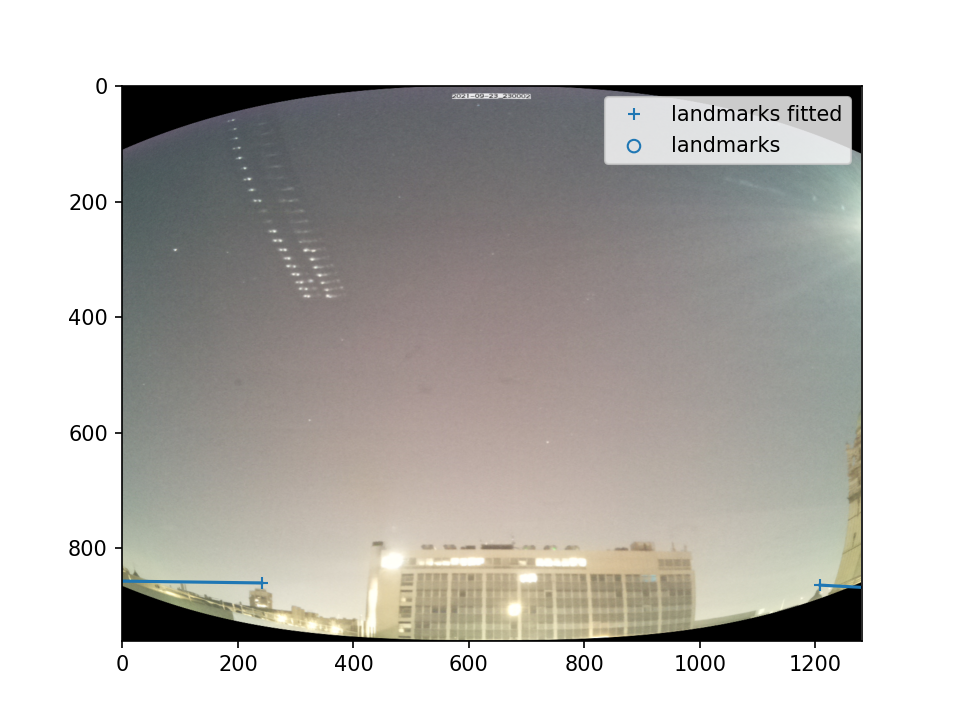

In [53]:
# plot fitted positions of landmarks on image
plt.figure()
camera3.plotFitInformation(im_undistorted)
plt.legend();
#plt.savefig('fittedLandmarks.png', bbox_inches='tight')

In [55]:
trace_array = trace.to_numpy()
elevation_m = trace_array[-1,0]
tilt_deg = trace_array[-1,1]
heading_deg =trace_array[-1,2]
roll_deg = trace_array[-1,3]
prob = trace_array[-1,4]

# Camera 3
### Now repeat process for camera 3:

- Import calibration image
- Undistort
- Create camera object
- search parameter space for best fitting orientation

<IPython.core.display.Javascript object>


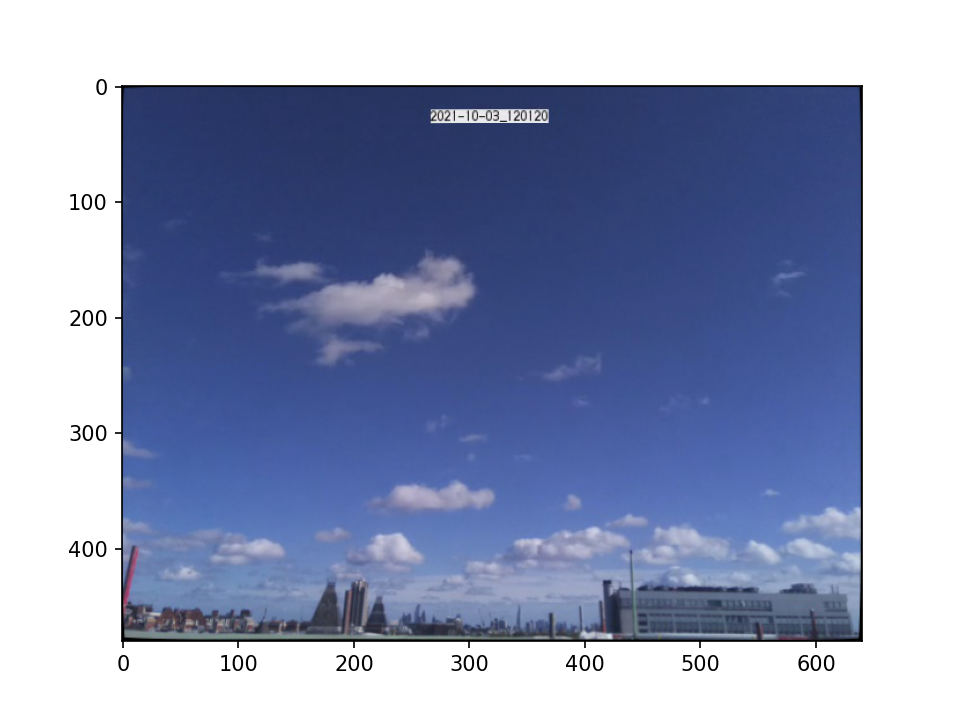

In [11]:
camM = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
                [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
                [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
distortion = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
w, h = 640, 480

#filepath = r"C:/Users/kathe/OneDrive - Imperial College London\MSci Project/longExposures/"
#filename = f'tl4_2021-09-23_230002_CAL1.jpg'
filepath = "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/output_C3_20211003_12/"
filename = "C3_031021_frame_14.jpg"

im = plt.imread(filepath+filename)
#im_big = cv.resize(im,(1280,960),fx=0,fy=0, interpolation = cv.INTER_CUBIC)

new_camM, roi = cv.getOptimalNewCameraMatrix(camM,distortion,(w,h),1,(w,h))

im_undistorted = cv.undistort(im, camM, distortion, None, new_camM)
fig, ax = plt.subplots(1,1)
ax.imshow(im_undistorted)

#plt.savefig('calib_C3_undistorted_1280x960.png', bbox_inches='tight')"C:\Users\kathe\OneDrive - Imperial College London\MSci Project\output_C3_20211004_11"

### Set up cameraTransform object and calibrate using landmarks

In [12]:
# intrinsic camera parameters
f_mm = 3.04    # in mm
pixel_size = 5.75e-3 # length of one side of square pixel in mm
sensor_size = (3.68, 2.76) # in mm
image_size = (640, 480)    # in px
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height

camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = im_undistorted))

camera.setGPSpos(51.4993318750954, -0.17901837289811393, 46)

#lm_points_px_1280 = np.array([[338.96,839.97],[708.53,897.53], [483.6,909.8], [506.03, 916.6], [472.0,899.3]]) #peninsula, shard, cheesegrater, scalpel, 22 bishops 
lm_points_px_640 = np.array([[206.5,424.8], [342.99,447.67], [260.4,452.8], [268.9,455.9], [256.4, 447.3]])
lm_points_gps = np.array([[51.50204599904154, -0.16672769065597756, 94], [51.504570716500965, -0.08649973661973948, 326], 
                          [51.514199912543596, -0.082157669459782, 266], [51.51327187191974, -0.08132082019621222, 232], [ 51.51438883427781, -0.08297279981969655, 315]])
#height of rcm tower estimated with google earth
lm_points_space = camera.spaceFromGPS(lm_points_gps)

camera.addLandmarkInformation(lm_points_px_640, lm_points_space, [3, 3, 20]) #last argument is the uncertainty in each gps coordinate

In [30]:
# find trace through the parameter space
trace = camera.metropolis([
        ct.FitParameter("elevation_m", lower=44, upper=48, value=46),
        ct.FitParameter("tilt_deg", lower=80, upper=150, value=112),
        ct.FitParameter("heading_deg", lower=0, upper=360, value=90),
        ct.FitParameter("roll_deg", lower=-20, upper=20, value=0)
        ], iterations=1e4)

100%|██████████| 10000/10000 [00:31<00:00, 319.96it/s, acc_rate=0.0466, factor=0.00738]


      elevation_m    tilt_deg  heading_deg  roll_deg    probability
0       47.434457  113.561524    83.218473 -2.698270 -244575.225753
1       47.434457  113.561524    83.218473 -2.698270 -244575.225753
2       47.434457  113.561524    83.218473 -2.698270 -244575.225753
3       47.434457  113.561524    83.218473 -2.698270 -244575.225753
4       47.434457  113.561524    83.218473 -2.698270 -244575.225753
...           ...         ...          ...       ...            ...
8994    46.540875  113.686310    82.703512 -1.305031 -243116.443873
8995    46.540875  113.686310    82.703512 -1.305031 -243116.443873
8996    46.540875  113.686310    82.703512 -1.305031 -243116.443873
8997    46.540875  113.686310    82.703512 -1.305031 -243116.443873
8998    46.540875  113.686310    82.703512 -1.305031 -243116.443873

[8999 rows x 5 columns]


<IPython.core.display.Javascript object>


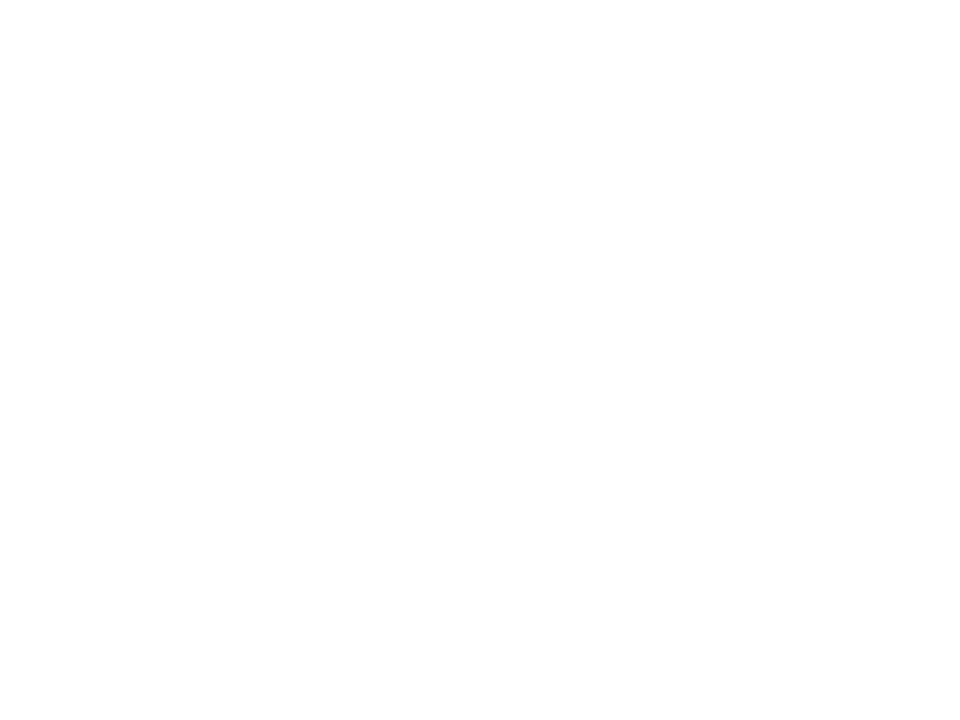

TypeError: 'NoneType' object is not subscriptable

In [13]:
# plot trace through parameter space
plt.figure()
camera.plotTrace()
plt.tight_layout()
#plt.savefig('640x480_C3_undistorted_trace.png', bbox_inches='tight')

## Manually finding the camera tilt using the known height/position of peninsula tower

In [14]:
camera3 = np.array([51.4993318750954, -0.17901837289811393, 46])
peninsula = np.array([51.50204599904154, -0.16672769065597756, 94])

distance = haversine([camera3[0], camera3[1]], [peninsula[0], peninsula[1]], unit='m')
print(distance)

elevation = np.arctan((peninsula[2] - camera3[2]) / distance)
print(elevation)

902.6991853296261
0.05312382909183692


In [16]:
f_mm = 3.04    # in mm
pixel_size = 5.75e-3 # length of one side of square pixel in mm

height_mm = f_mm * np.tan(elevation)
height_px = height_mm / pixel_size 

print(height_mm, height_px)

0.16164853405369634 144.3290482622289


peninsula tower is actually 55px upwards from the bottom of the image, so 185px below image centre.

In [55]:
f_x_px = 5.520688775958645920e+02
f_y_px = 5.502640890663026312e+02
c_x_px = 3.225866125962970159e+02
c_y_px = 2.362389385357402034e+02
tilt = 23.30 * np.pi/180

#peninsula, shard, cheesegrater, scalpel, 22 bishops
lm_points_px_640 = np.array([[206.5,424.8], [342.99,447.67], [260.4,452.8], [268.9,455.9], [256.4, 447.3]])
lm_points_gps = np.array([[51.50204599904154, -0.16672769065597756, 94], [51.504570716500965, -0.08649973661973948, 326], 
                          [51.514199912543596, -0.082157669459782, 266], [51.51327187191974, -0.08132082019621222, 232], 
                          [ 51.51438883427781, -0.08297279981969655, 315]])
lm_dists = []
for building in lm_points_gps:
    dist = haversine( (camera3[0], camera3[1]), (building[0], building[1]), unit=Unit.METERS)
    lm_dists.append(dist)
    
lm_dists = np.array(lm_dists)

cam_azi = np.arctan( (lm_points_px_640[:,0] - c_x_px) / f_x_px )
cam_elev = np.arctan( (c_y_px - lm_points_px_640[:,1]) / f_y_px )
heights = lm_dists * np.tan(tilt + cam_elev) + 46
print(heights)

lm_widths = []


[115.21736514 302.1842541  265.09270155 232.32093668 323.12294206]
